In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam, RMSprop, SGD

In [2]:
df = pd.read_csv("../processed_adhdata.csv")
df['Class'] = LabelEncoder().fit_transform(df['Class'])  # ADHD->1, Control->0

frequency_count = len(df['Frequency'].unique())
window_count = len(df['Window'].unique())
numeric_df = df.drop(['ID', 'Window'], axis=1)

# shape: (windows, freqs, features)
full_ndarray = numeric_df.values.reshape(
    (window_count, frequency_count, numeric_df.shape[1])
)

X = full_ndarray[:, :, 2:]     # drop ID/Class columns
y = full_ndarray[:, 0, 0]      # class label is repeated across freq rows

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Add channel dimension (N, 1, freq, electrodes)
X_train = X_train[..., np.newaxis]   # (N, freq, electrodes, 1)
X_test  = X_test[...,  np.newaxis]

# Standardize across the entire dataset
scaler = StandardScaler()
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat  = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled  = scaler.transform(X_test_flat)

X_train = X_train_scaled.reshape(X_train.shape)
X_test  = X_test_scaled.reshape(X_test.shape)

print("Train shape:", X_train.shape)  # (N, freq, electrodes, 1)

Train shape: (6623, 77, 19, 1)


In [3]:
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).permute(0, 3, 1, 2)  
        # -> (N, 1, freq, electrodes)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = EEGDataset(X_train, y_train)
test_ds  = EEGDataset(X_test,  y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

class EEG_SVM:
    def __init__(self, kernel='rbf', C=1.0, gamma='scale', random_state=42):
        self.model = SVC(kernel=kernel, C=C, gamma=gamma, probability=True, random_state=random_state)

    def fit(self, train_loader, test_loader=None):
        # --- Flatten training data ---
        X_train, y_train = [], []
        for xb, yb in train_loader:
            X_train.append(xb.numpy().reshape(xb.size(0), -1))
            y_train.append(yb.numpy())
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)

        # Train SVM
        print("Fitting SVM Model")
        self.model.fit(X_train, y_train)

        history = {}
        if test_loader is not None:
            # --- Flatten validation data ---
            X_val, y_val = [], []
            for xb, yb in test_loader:
                X_val.append(xb.numpy().reshape(xb.size(0), -1))
                y_val.append(yb.numpy())
            X_val = np.concatenate(X_val, axis=0)
            y_val = np.concatenate(y_val, axis=0)

            y_train_pred = self.model.predict(X_train)
            y_val_pred   = self.model.predict(X_val)

            history['train_acc'] = accuracy_score(y_train, y_train_pred)
            history['val_acc']   = accuracy_score(y_val, y_val_pred)

            print("Train Accuracy:", history['train_acc'])
            print("Validation Accuracy:", history['val_acc'])
            print("\nValidation Classification Report:\n", classification_report(y_val, y_val_pred))
            print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))

        return history

    def predict(self, X):
        if isinstance(X, torch.Tensor):
            X = X.numpy().reshape(X.shape[0], -1)
        return self.model.predict(X)


In [5]:
input_size = X_train.shape[2]  # number of electrodes
svm_model = EEG_SVM(kernel='rbf', C=1.0, gamma='scale')

history = svm_model.fit(train_loader, test_loader)

Fitting SVM Model
Train Accuracy: 0.7039106145251397
Validation Accuracy: 0.6781400966183575

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.94      0.77       925
           1       0.83      0.34      0.48       731

    accuracy                           0.68      1656
   macro avg       0.74      0.64      0.62      1656
weighted avg       0.73      0.68      0.64      1656

Confusion Matrix:
 [[874  51]
 [482 249]]


In [6]:
all_preds, all_labels = [], []

for xb, yb in test_loader:
    # xb: (batch, freq, electrodes, 1) or (batch, freq, electrodes)
    preds = svm_model.predict(xb)  # handles torch tensors and flattens automatically
    all_preds.append(preds)
    all_labels.append(yb.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\nTest Accuracy:", accuracy_score(all_labels, all_preds))
print(classification_report(all_labels, all_preds))
print(confusion_matrix(all_labels, all_preds))


Test Accuracy: 0.6781400966183575
              precision    recall  f1-score   support

           0       0.64      0.94      0.77       925
           1       0.83      0.34      0.48       731

    accuracy                           0.68      1656
   macro avg       0.74      0.64      0.62      1656
weighted avg       0.73      0.68      0.64      1656

[[874  51]
 [482 249]]


KeyError: 'train_accs'

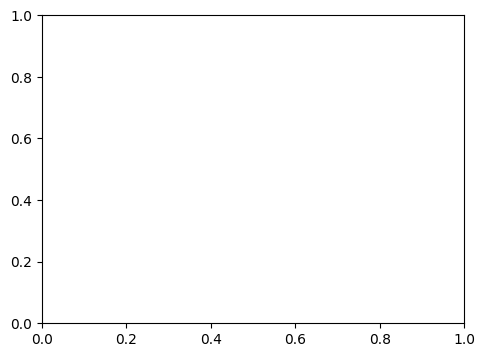

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_accs'], label='Training Accuracy')
plt.plot(history['val_accs'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_losses'], label='Training Loss')
plt.plot(history['val_losses'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()